# Tutorial 4: The temporal model
In tutorials 1-3 we have used simple fully-connected neural networks to predict sources from single time instances of EEG data. To harness the full information within the EEG, however, we can also incorporate multiple time instances at once. 

For time-series data we can use recurrent neural networks (RNNs). A prominent RNN is the long-short-term memory (LSTM) network, which makes use of temporal information in a quite useful manner.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import mne
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
plot_params = dict(surface='white', hemi='both', verbose=0)


## Forward model
To get started we just create some generic forward model using the esinet.forward module.

In [2]:
info = get_info()
info['sfreq'] = 100
fwd = create_forward_model(info=info)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


## Simulation
Next, we simulate our training data. In order to invoke the LSTM architecture we need to simulate data that have a temporal dimension. This is controlled via the *duration_of_trial* setting as shown below. We set the duration to 0.2 seconds, which together with our sampling rate of 100 Hz yields 20 time points:
```
100 Hz * 0.2 s = 20
```

Note, that for publication-ready inverse solutions you should increase the number of training samples to 100,000.

In [3]:
n_samples = 50000
settings = dict(duration_of_trial=0.2, target_snr=1)
sim_lstm = Simulation(fwd, info, verbose=True, settings=settings).simulate(n_samples=n_samples)

sim_dense = util.convert_simulation_temporal_to_single(sim_lstm)

Simulate Source


  0%|          | 0/50000 [00:00<?, ?it/s]

In [19]:
kwargs = dict(epochs=500, patience=100, tensorboard=True, learning_rate=0.005)

# Pretraining
net_lstm = Net(fwd, model_type='temporal', activation_function='relu').fit(sim_dense, **kwargs)
net_dense = Net(fwd, model_type='auto', activation_function='relu').fit(sim_dense, **kwargs)

# Post-training
net_lstm.fit(sim_lstm, **kwargs)
net_dense.fit(sim_dense, **kwargs)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, None, 200)         129600    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1284)        258084    
Total params: 387,684
Trainable params: 387,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
106/106 [==============================] - 7s 44ms/step - loss: 0.0100 - val_loss: 0.0080
Epoch 2/50
106/106 [==============================] - 4s 35ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 3/50
106/106 [==============================] - 4s 37ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 4/50
 87/106 [=======================>......] - ETA: 0s - loss: 0.0079

KeyboardInterrupt: 

In [ ]:
net_lstm._unfreeze_fc()
net_lstm._freeze_fc()

# Retraining
kwargs = dict(epochs=20, patience=20, tensorboard=True, learning_rate=0.005, batch_size=32)
net_lstm.fit(sim_lstm, **kwargs)

# Retraining whole
net_lstm._unfreeze_fc()
kwargs = dict(epochs=20, patience=20, tensorboard=True, learning_rate=0.005, batch_size=32)
net_lstm.fit(sim_lstm, **kwargs)

## Build & train LSTM network
The neural network class *Net()* is intelligent and recognizes the temporal structure in the simulations.
It will automatically build the LSTM network architecture without further specification.

In [ ]:
kwargs = dict(epochs=25, patience=15, return_history=True, tensorboard=True, learning_rate=0.005)
# Pretrain 
net_dense, hist_dense = Net(fwd, activation_function='relu').fit(sim_dense, **kwargs)
# net_lstm, hist_lstm = Net(fwd, model='temporal').fit(sim_dense, **kwargs)

# Retrain
# kwargs = dict(epochs=20, patience=7, return_history=True, tensorboard=True, learning_rate=0.005)
# net_lstm.fit(sim_lstm, **kwargs, batch_size=64)
# net_dense.fit(sim_dense, **kwargs)



In [ ]:
settings_eval = deepcopy(settings)
settings_eval['duration_of_trial'] = 1
n_samples = 20


sim_eval = Simulation(fwd, info, verbose=True, settings=settings_eval).simulate(n_samples=n_samples)
sim_eval_dense = util.convert_simulation_temporal_to_single(sim_eval)

pred_lstm = net_lstm.predict(sim_eval)
pred_dense = net_lstm.predict(sim_eval_dense)

errors_lstm = np.zeros((n_samples))
errors_dense = np.zeros((n_samples * settings_eval['duration_of_trial']))

for i in range(len(errors_lstm)):
    y = sim_eval.source_data[i].data
    y_hat = pred_lstm[i].data
    errors_lstm[i] = np.mean((y-y_hat)**2)

for i in range(len(errors_dense)):
    y = sim_eval_dense.source_data.data[:, i]
    y_hat = pred_dense.data[:, i]
    errors_dense[i] = np.mean((y-y_hat)**2)

print(f'ERRORS\nLSTM: {np.median(errors_lstm)}\nDense: {np.median(errors_dense)}')

In [ ]:
sim_eval.eeg_data[0].average().plot()
sim_eval.eeg_data[0].average().plot_topomap()


## Evaluate performance
We can now evaluate the performance of our LSTM network using a newly simulated, thus unseen simulated sample.

In [15]:
%matplotlib qt
settings['duration_of_trial'] = 0.03
settings['target_snr'] = 1

# Simulate new data
sim_test = Simulation(fwd, info, settings=settings).simulate(1)
idx = 0
# Predict sources
prediction_dense = net_dense.predict(sim_test)
prediction_lstm = net_lstm.predict(sim_test)


# Plot True Source
brain = sim_test.source_data[idx].plot(**plot_params)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title')

# Plot True EEG
evoked = sim_test.eeg_data[idx].average()
evoked.plot()
evoked.plot_topomap(title='Ground Truth')
evoked = util.get_eeg_from_source(sim_test.source_data[idx], fwd, info, tmin=0.)
evoked.plot_topomap(title='Ground Truth Noiseless')


# Plot predicted source Dense
brain = prediction_dense.plot(**plot_params)
brain.add_text(0.1, 0.9, 'Dense', 'title')
# Plot predicted EEG
evoked_esi = util.get_eeg_from_source(prediction_dense, fwd, info, tmin=0.)
evoked_esi.plot()
evoked_esi.plot_topomap(title='Dense')

# Plot predicted source LSTM
brain = prediction_lstm.plot(**plot_params)
brain.add_text(0.1, 0.9, 'LSTM', 'title')
# Plot predicted EEG
evoked_esi = util.get_eeg_from_source(prediction_lstm, fwd, info, tmin=0.)
evoked_esi.plot()
evoked_esi.plot_topomap(title='LSTM')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

NameError: name 'net_dense' is not defined

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

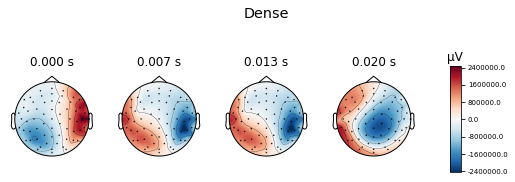

  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.00019979 0.00023367 0.00195532]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [2.47817747e-09 4.23466398e-09 1.09282661e-08]


In [16]:
%matplotlib qt
settings['duration_of_trial'] = 0.03
settings['target_snr'] = 1

# Simulate new data
sim_test = Simulation(fwd, info, settings=settings).simulate(1)
idx = 0
# Predict sources
prediction_dense = net.predict(sim_test)


# Plot True Source
brain = sim_test.source_data[idx].plot(**plot_params)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title')

# Plot True EEG
evoked = sim_test.eeg_data[idx].average()
evoked.plot()
evoked.plot_topomap(title='Ground Truth')
evoked = util.get_eeg_from_source(sim_test.source_data[idx], fwd, info, tmin=0.)
evoked.plot_topomap(title='Ground Truth Noiseless')


# Plot predicted source Dense
brain = prediction_dense.plot(**plot_params)
brain.add_text(0.1, 0.9, 'Dense', 'title')
# Plot predicted EEG
evoked_esi = util.get_eeg_from_source(prediction_dense, fwd, info, tmin=0.)
evoked_esi.plot()
evoked_esi.plot_topomap(title='Dense')

